This ipynb aims to classify products into their categories

Importing the libraries

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, LSTM,
                                     Dropout, GlobalMaxPooling1D)

Loading the dataset

In [2]:
# Load dataset
file_path = r"Datasets\dummy_products.csv"
df = pd.read_csv(file_path)

In [82]:
print(df.head())

                   name                                        description  \
0    Red Cotton T-Shirt  Comfortable red cotton t-shirt with a round ne...   
1  16GB USB Flash Drive  High-speed 16GB USB flash drive with a durable...   
2         Running Shoes  Lightweight running shoes with breathable mesh...   
3        Leather Wallet  Premium leather wallet with multiple compartme...   
4            Smartphone  Latest smartphone with 6GB RAM, 128GB storage,...   

    price     category  
0   19.99     Clothing  
1    9.99  Electronics  
2   49.99     Footwear  
3   29.99  Accessories  
4  299.99  Electronics  


Data preprocessing

In [83]:
# Initialize Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df["description"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["description"])

# Pad sequences to ensure uniform input size
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, padding="post",
                                 maxlen=max_sequence_length)

In [85]:
# Load GloVe embeddings


def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index


glove_embeddings = load_glove_embeddings(r"Datasets\glove.6B.100d.txt")

In [86]:
# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in glove_embeddings:
        embedding_matrix[i] = glove_embeddings[word]

In [87]:
label_encoder = LabelEncoder()
df["encoded_category"] = label_encoder.fit_transform(df["category"])
num_classes = len(label_encoder.classes_)

In [88]:
X = padded_sequences
y = df["encoded_category"].values

In [89]:
print("Padded sequences shape:", X.shape)
print("Encoded labels shape:", y.shape)

Padded sequences shape: (42, 16)
Encoded labels shape: (42,)


Data visualization

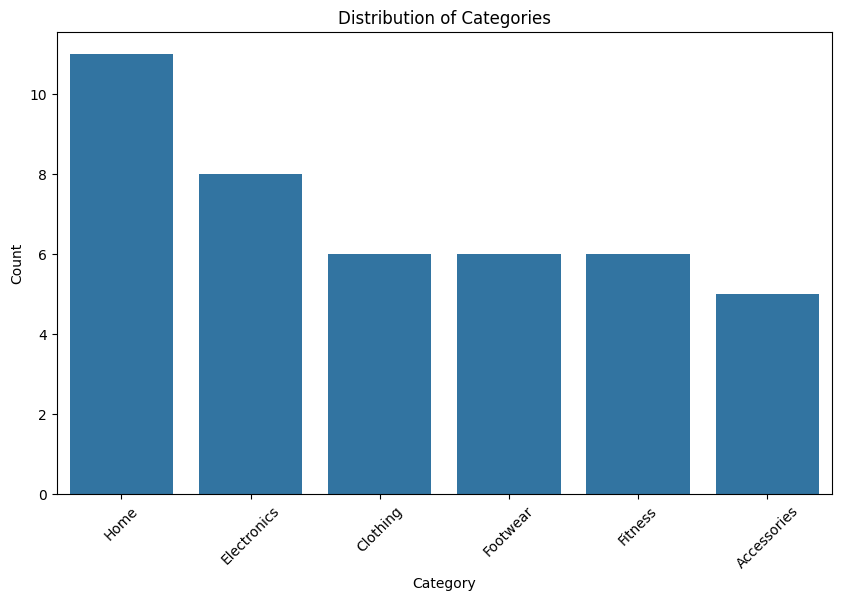

In [90]:
# Plot distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="category", order=df["category"].value_counts().index)
plt.title("Distribution of Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

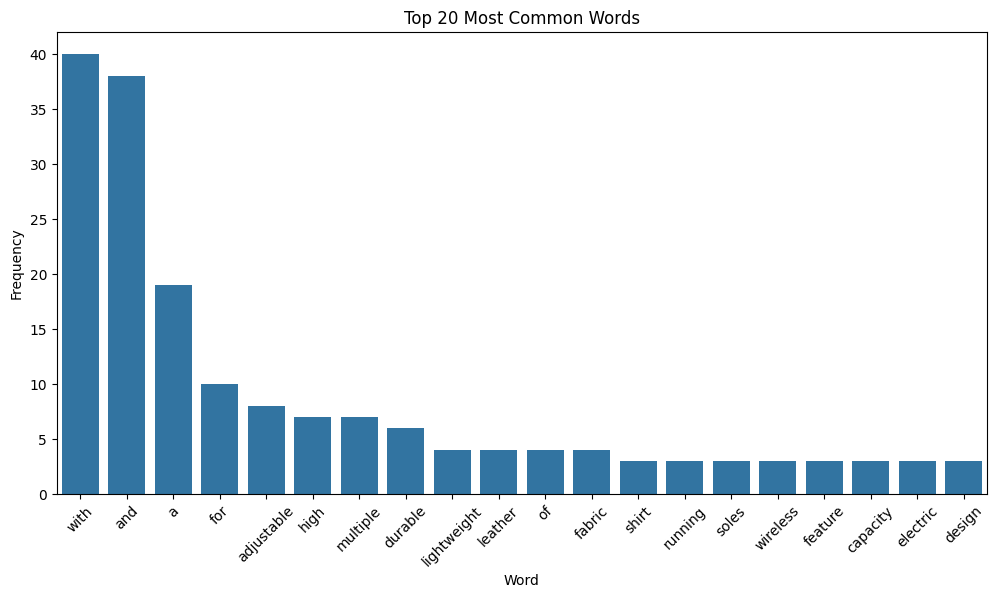

In [91]:
# Tokenize descriptions and flatten list
all_words = [word for seq in sequences for word in seq]

# Count word frequencies
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)  # Top 20 words

# Create a mapping from word ID to word
index_word = {index: word for word, index in tokenizer.word_index.items()}

# Convert to DataFrame for easier plotting
word_df = pd.DataFrame(
    {
        "Word": [index_word.get(word_id, "Unknown") for word_id,
                 _ in most_common_words],
        "Frequency": [freq for _, freq in most_common_words],
    }
)

# Plot word frequency distribution
plt.figure(figsize=(12, 6))
sns.barplot(x="Word", y="Frequency", data=word_df)
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


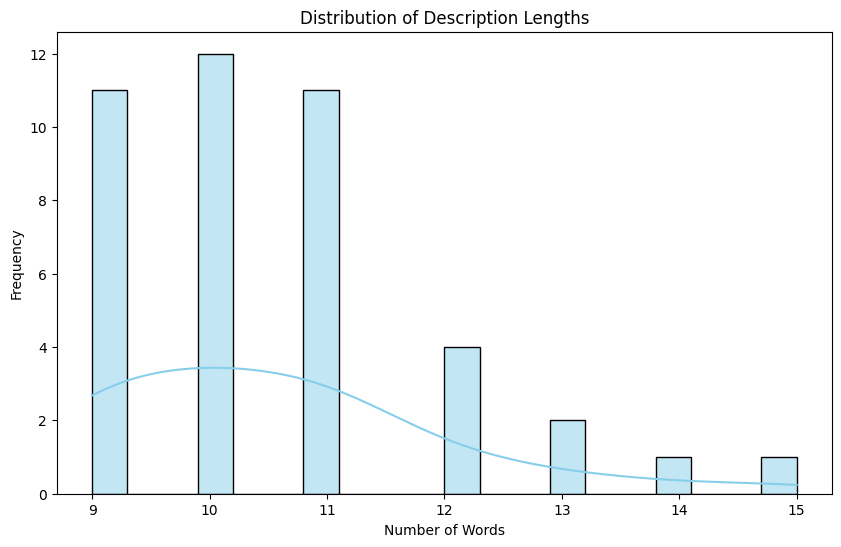

In [92]:
# Calculate the length of each description
df["description_length"] = df["description"].apply(lambda x: len(x.split()))

# Plot distribution of description lengths
plt.figure(figsize=(10, 6))
sns.histplot(df["description_length"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Description Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

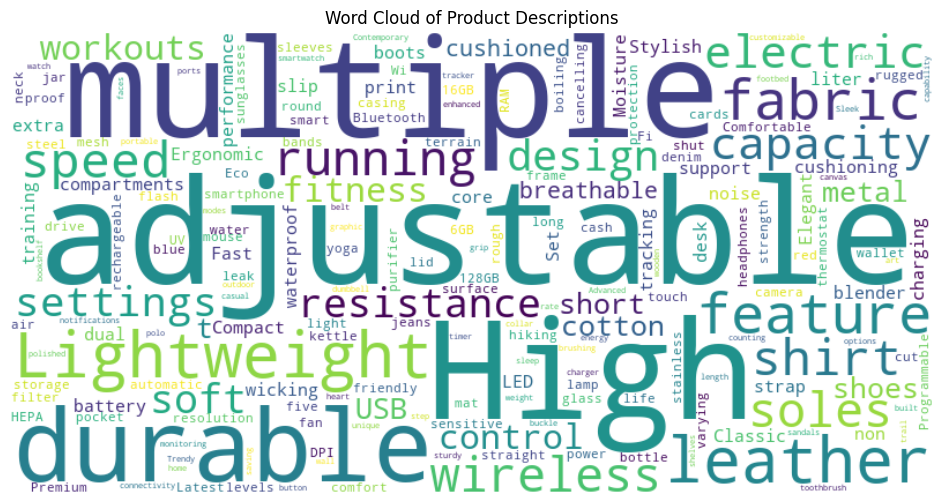

In [93]:
# Combine all descriptions into a single string
text = " ".join(df["description"])

# Create a word cloud object
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap="viridis"
).generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Product Descriptions")
plt.show()

Splitting the data

In [94]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=42)

Defining the model

In [95]:
model = Sequential(
    [
        Embedding(
            input_dim=len(word_index) + 1,
            output_dim=100,
            weights=[embedding_matrix],
            trainable=False,
        ),
        LSTM(128, return_sequences=True),
        GlobalMaxPooling1D(),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

In [96]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Training the model

In [104]:
history = model.fit(
    X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val)
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9697 - loss: 0.1278 - val_accuracy: 0.6667 - val_loss: 1.3618
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0703 - val_accuracy: 0.6667 - val_loss: 1.3727
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0759 - val_accuracy: 0.6667 - val_loss: 1.4040
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0422 - val_accuracy: 0.6667 - val_loss: 1.4363
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 0.0518 - val_accuracy: 0.6667 - val_loss: 1.4700
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9697 - loss: 0.0637 - val_accuracy: 0.6667 - val_loss: 1.4899
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9697 - loss: 0.0997 - val_accuracy: 0.6667 - val_loss: 1.4971
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0294 - val_accuracy: 0.6667 - val_loss: 1.

Evaluating the model

In [105]:
# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [106]:
# Print classification report with zero_division parameter
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, zero_division=0))
print("Accuracy Score:")
print(accuracy_score(y_val, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      1.00      0.50         1
           2       1.00      0.67      0.80         3
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         2
           5       1.00      0.50      0.67         2

    accuracy                           0.67         9
   macro avg       0.56      0.53      0.49         9
weighted avg       0.81      0.67      0.69         9

Accuracy Score:
0.6666666666666666


Training history

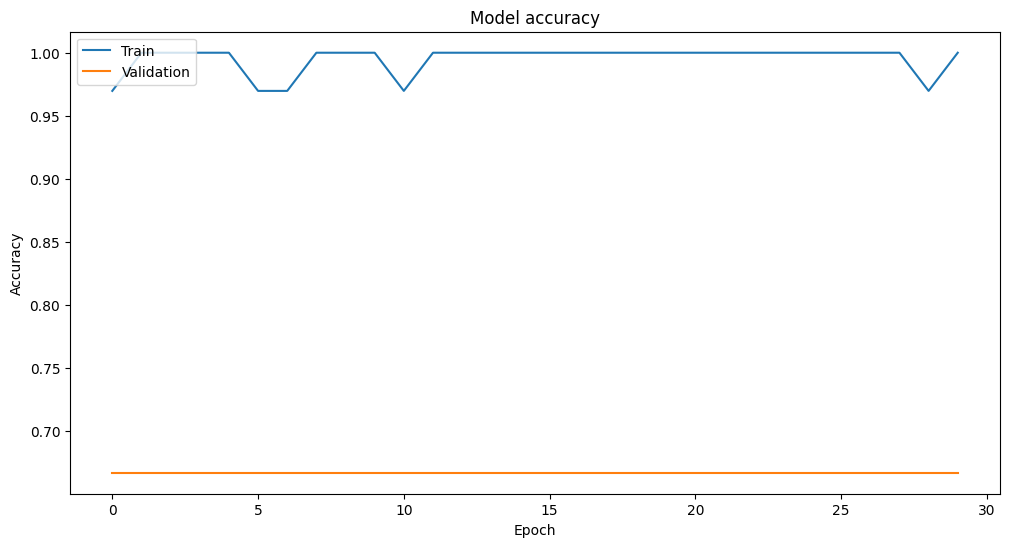

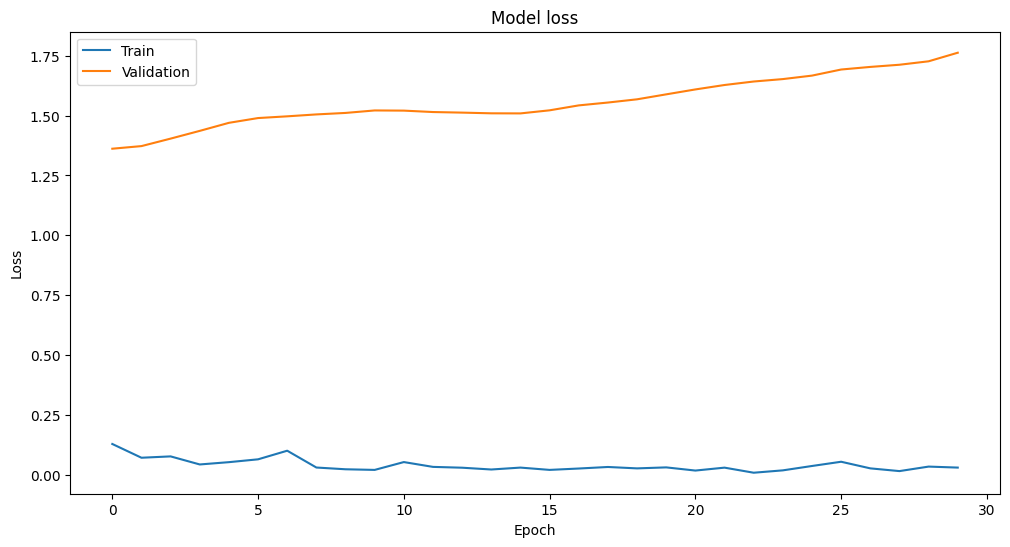

In [107]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

Category Prediction

In [108]:


def predict_category(text, tokenizer, model, max_sequence_length=100):
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length,
                                    padding="post")

    # Convert the padded sequence to a tensor
    padded_sequence = tf.convert_to_tensor(padded_sequence, dtype=tf.float32)

    # Predict the class probabilities
    probabilities = model.predict(padded_sequence, verbose=0)[0]

    # Get the predicted class and confidence score
    predicted_class = np.argmax(probabilities)
    confidence_score = probabilities[predicted_class]

    # Convert class index to category label
    category_label = label_encoder.inverse_transform([predicted_class])[0]

    return category_label, confidence_score

In [109]:


text = "Comfortable red cotton t-shirt with a round neck and short sleeves."
category, confidence = predict_category(text, tokenizer, model)
print(f"Category: {category}")
print(f"Confidence: {confidence:.4f}")

Category: Clothing
Confidence: 0.9972


Testing the model on a csv

In [3]:
# Load the sample test data
test_data_path = (r"Datasets\test.csv")
test_df = pd.read_csv(test_data_path)

In [111]:
# Tokenize and pad the descriptions
sequences = tokenizer.texts_to_sequences(test_df["description"])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length,
                                 padding="post")

In [112]:
# Predict the categories
predictions = model.predict(padded_sequences)
predicted_classes = np.argmax(predictions, axis=1)

# Output predictions
predicted_categories = label_encoder.inverse_transform(predicted_classes)
test_df["predicted_category"] = predicted_categories

# Display the DataFrame with predictions
print(test_df[["description", "predicted_category"]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
                                         description predicted_category
0  Advanced air purifier with smart sensors and m...               Home
1  Portable waterproof Bluetooth speaker with hig...        Electronics
2  Set of adjustable dumbbells with a range of we...            Fitness
3  Modern LED desk lamp with adjustable brightnes...               Home
4  Premium organic green tea with a refreshing ta...               Home
